In [1]:
# HTML: https://s3.amazonaws.com/assets.mailcharts.com/emails/3b9666be-1ddc-952f-329e-6e832911892e/index.html
# JSON: https://s3.amazonaws.com/assets.mailcharts.com/~emails:3b9666be-1ddc-952f-329e-6e832911892e.json

In [2]:
from bs4 import BeautifulSoup
from collections import Counter
from collections import defaultdict
from io import BytesIO
import math
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag as word_type
import numpy as np
import pandas as pd
from PIL import Image
import pytesseract
import re
import requests
import string

In [3]:
# Google vision
from google.cloud import vision
from google.cloud.vision import types
import os

path="/Users/carl/sites/google.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=path

In [4]:
# Helper functions to prepare category data

def create_full_category(row):
    result = row.category_1.lower()
    
    if row.category_2:
        result = result + " > " + row.category_2.lower()
    if row.category_3:
        result = result + " > " + row.category_3.lower()
    if row.category_4:
        result = result + " > " + row.category_4.lower()
    if row.category_5:
        result = result + " > " + row.category_5.lower()
    if row.category_6:
        result = result + " > " + row.category_6.lower()
    if row.category_7:
        result = result + " > " + row.category_7.lower()

    return result

def get_lookup_value(row):    
    if row.lookup_value:
        return row.lookup_value.lower().split("|")
    if row.category_7:
        return [row.category_7.lower()]
    if row.category_6:
        return [row.category_6.lower()]
    if row.category_5:
        return [row.category_5.lower()]
    if row.category_4:
        return [row.category_4.lower()]
    if row.category_3:
        return [row.category_3.lower()]
    if row.category_2:
        return [row.category_2.lower()]
    if row.category_1:
        return [row.category_1.lower()]

In [5]:
# Create category DF
categories_df = pd.read_csv("./data/taxonomy-carl.csv", encoding="ISO-8859-1", dtype=str)
categories_df.fillna(False, inplace=True)
categories_df["full_category"] = categories_df.apply(lambda x: create_full_category(x), axis=1)
categories_df["lookup_value"] = categories_df.apply(lambda x: get_lookup_value(x), axis=1)

In [6]:
# Email text cleaner

lemmatizer = WordNetLemmatizer()
punctuation = r"\+|\:|\{|\\|\(|\-|\`|\<|\?|\*|\;|\_|\@|\'|\[|\}|\)|\,|\/|\"|\$|\=|\&|\]|\!|\%|\>|\^|\~|\||\.|\#"

def clean_email_text(content):
    if type(content) == float and np.isnan(content): # prevent blowup if nan
        return ""
    content = " ".join(content.split("_")) # prevents blowup if subjects are concatenated with "_"
    content = " ".join(content.split("\n"))
    lowered = str(content).lower()
    no_punct = re.sub(punctuation, "", lowered)
    alpha = " ".join([word for word in no_punct.split(" ") if word.isalpha()])
    nouns = " ".join([word[0] for word in word_type(alpha.strip().split(" ")) if word[1] != "VB"])
    singulars = " ".join([lemmatizer.lemmatize(word) for word in nouns.split(" ") if word.isalpha()])
    return singulars

In [7]:
# Content matching functions

def contains_word(s, w):
    return (' ' + w + ' ') in (' ' + s + ' ')

def contains_word_with_counter(i, s, w):
    return (i, s.count(w))

def find_matches(text):
    text = clean_email_text(text)
    categories = []
    
    for i, row in categories_df.iterrows():
        category_to_find = row["lookup_value"]
        for c in category_to_find:
            if contains_word(text, c):
                categories.append(contains_word_with_counter(i, text, c))
    return categories

In [8]:
# See which images we need to process

def get_image_size(url):
    data = requests.get(url).content
    im = Image.open(BytesIO(data))    
    return im.size

def get_images_to_analyze(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')

    images_to_analyze = []

    for img in soup.findAll('img'):
        img_url = "https://s3.amazonaws.com/assets.mailcharts.com/emails/" + guid + "/" + img["src"]
        try:
            width, height = get_image_size(img_url)
            area = width * height
            if area > 10000:
                images_to_analyze.append(img_url)
        except:
            pass

    return images_to_analyze


# OCR
# def process_image_ocr(images):
#     ocr_results = []
    
#     for image in images:
#         # TODO: We need to convert gifs to JPEGs
#         # https://pillow.readthedocs.io/en/5.1.x/reference/plugins.html#module-PIL.GifImagePlugin
#         if image.endswith(".gif"):
#             print("skipping gif")
#         else:
#             response = requests.get(image)
#             img = Image.open(BytesIO(response.content))
#             text = pytesseract.image_to_string(img)
#             ocr_results.append(text + " ")
#     return " ".join(ocr_results)

def get_images_data(images):
    text_results = ""
    image_results = ""
    
    for image in images:
        client = vision.ImageAnnotatorClient()
        request = {'image': {'source': {'image_uri': image},},}
        response = client.annotate_image(request)
        text = " ".join([l.description for l in response.text_annotations])
        label = " ".join([l.description for l in response.label_annotations])
        web = " ".join([l.description for l in response.web_detection.web_entities])

        text_results = text_results + text + " "
        image_results = image_results + label + " "

    return (text_results, image_results)

In [9]:
# image_content, image_text, subject_body

WEIGHTS = {
    "subject": 0.20,
    "body": 0.10,
    "image_text": 0.25,
    "image_content": 0.45
}

def calculate_result(subject, body, image_text, image_content): 
    # Calculate weight
    subject = [(s[0], s[1]*WEIGHTS["subject"]) for s in subject]
    body = [(s[0], s[1]*WEIGHTS["body"]) for s in body]
    image_text = [(s[0], s[1]*WEIGHTS["image_text"]) for s in image_text]
    image_content = [(s[0], s[1]*WEIGHTS["image_content"]) for s in image_content]
    
    # combine all of them
    subject.extend(body)
    subject.extend(image_text)
    subject.extend(image_content)
    
    # add the results
    d = defaultdict(float)

    for i in subject:
        d[i[0]] +=i[1]

    return sorted(d.items(), key=lambda t: t[1], reverse=True)

def categorize(subject, full_text, image_text, image_content):
    subject = find_matches(subject)
    full_text = find_matches(full_text)
    image_text = find_matches(image_text)
    image_content = find_matches(image_content)
    return calculate_result(subject, full_text, image_text, image_content)

def list_categories(res):
    total_points = sum([result[1] for result in results])
    cutoff = total_points * 0.1
    
    categories = []
    for category_index, value in res:
        if value >= 0 and total_points > cutoff:
            categories.append((categories_df.iloc[category_index]["full_category"], value))
            total_points = total_points - value
    return categories

In [12]:
df = pd.read_csv("./data/emails-tag-1100.csv", encoding="ISO-8859-1", dtype=str)
df["subject"] = df["subject"].apply(lambda x: clean_email_text(x))
df["full_text"] = df["full_text"].apply(lambda x: clean_email_text(x))
df = df.iloc[:10]

In [13]:
position = 1
subject = df.iloc[position]["subject"]
full_text = df.iloc[position]["full_text"]
guid = df.iloc[position]["guid"]
url = "https://s3.amazonaws.com/assets.mailcharts.com/emails/" + guid + "/index.html"
images = get_images_to_analyze(url)
image_text, image_content = get_images_data(images)

print("https://www.mailcharts.com/emails/" + df.iloc[position]["guid"])

https://www.mailcharts.com/emails/3b9666be-1ddc-952f-329e-6e832911892e


In [14]:
results = categorize(subject, full_text, image_text, image_content)
list_categories(results)

[('accessory > sunglass', 0.55)]

In [ ]:
# Ideas for improvement
# [X] Look at google web results
# [X] Exclude values in the lowest N%
# [ ] Only return the lowest level for a given category
# [ ] Classify images by surface area and only look at top N% (e.g. 80%)

# Making this more data scien-cy
# Cluster companies based on similar content

In [237]:
import json
df = pd.read_csv("./data/companies_to_productize.csv", encoding="ISO-8859-1", dtype=str)
df = df.iloc[105:]

In [236]:
results = []
from time import sleep

for i, row in df.iterrows():
    print(i)
    item = row
    
    url = "http://localhost:9000/api"
    data = json.dumps({'subject':item["subject"],'full_text':item["full_text"], 'guid':item["guid"]}) 
    r = requests.post(url, data)
    print(r)
    print("===")
    results.append(r.json())
    f = open("saved_productization_results.txt", "a")
    f.write("%s\n" % r.json())
    f.close()
    sleep(2) # sleep to prevent google vision timeout


104
<Response [200]>
===
105
<Response [500]>
===


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [132]:
# Next steps
# Gather email data for 10 companies for last month
# jcrew, gap, uniqlo, banana republic, old navy, nike, coach, brooks brother
# Will work with Koyuki to cluster companies based on similar content

# copy (select emails.company_id, companies.name, emails.guid, emails.sent_at, emails.subject, emails.full_text from emails join companies on emails.company_id = companies.id where company_id in (144, 137, 7, 277, 2939, 285, 665, 70, 220, 5097, 209) and sent_at > '2018-01-01' and entity_state != 'duplicate') to '/tmp/companies_to_productize.csv' with csv HEADER;
# results: http://share.mailcharts.com/070r0B2M1x0n

In [212]:
df = pd.read_csv("./data/companies_to_productize.csv", encoding="ISO-8859-1", dtype=str)
df = df.iloc[:75]
df

,company_id,name,guid,sent_at,subject,full_text
0,7,Nike,773f6b5f-4ef1-68fd-6a62-5da3fe650d09,2018-01-09 08:39:59,Trending Now: Black & White â¬ â¬,Two shades to rule them all. âÂ âÂ âÂ â...
1,665,Everlane,2052ae03-0853-503c-1b26-fefda9d97dc7,2018-01-11 13:51:40,Our Coolest Fleece Yet,Forward fleece sweatshirts are here. âÂ âÂ...
2,2939,Brooks Brothers,6b3e2b14-55f4-9339-0f45-cc9227346e74,2018-01-18 12:11:06,A shoe 200 years in the making,Style meets function meets value View in web b...
3,665,Everlane,250c1117-7522-c211-d8f4-04dd424283a6,2018-01-11 16:51:33,Introducing 365 Fleece,Sweats to wear all year long. âÂ âÂ âÂ â...
4,2939,Brooks Brothers,351d88dd-3958-a555-0507-468f49fafdd9,2018-01-11 17:04:15,Plan your visit â shop new arrivals,Up to 80% off clearance - limited time only Vi...
5,209,Kate Spade,89856ef5-3ae4-980e-4416-006b00b85a86,2018-01-25 14:26:05,footwear frills,kate spade new york make feet happy. shop now ...
6,7,Nike,18da28b9-0da1-99b6-daed-8b2ab085eb09,2018-01-09 22:02:44,A New Collection from Sig Zane and John John F...,JJF x Sig Zane. JJF x Sig Zane. âÂ âÂ âÂ...
7,2939,Brooks Brothers,0b6eae01-1cf4-d393-144a-92488175e05f,2018-01-11 20:08:48,Be part of our anniversary kickoff: Exclusive ...,200 years of American style on display View in...
8,7,Nike,a424c6f8-4e1a-6ab1-5be7-e0b27cf3e915,2018-01-11 20:50:22,AF-1: The force is female,Fresh footwear styles for the women who run th...
9,209,Kate Spade,ac7a36bc-07bd-b53a-a91c-df5b6877bbf9,2018-01-01 14:28:06,i resolve to...celebrate every day.,"kate spade new york a happy new year note, fro..."


In [121]:
categories = []

with open("saved_productization_results.txt", "r") as f:
    for line in f.readlines():
        categories.append(line)

In [135]:
df["products"] = categories

In [138]:
df.head(3)

,company_id,name,guid,sent_at,subject,full_text,products
0,7,Nike,773f6b5f-4ef1-68fd-6a62-5da3fe650d09,2018-01-09 08:39:59,Trending Now: Black & White â¬ â¬,Two shades to rule them all. âÂ âÂ âÂ â...,"{'results': [['shoe', 1.8], ['clothing', 0.45]..."
1,665,Everlane,2052ae03-0853-503c-1b26-fefda9d97dc7,2018-01-11 13:51:40,Our Coolest Fleece Yet,Forward fleece sweatshirts are here. âÂ âÂ...,"{'results': [['clothing > outerwear > hoodie',..."
2,2939,Brooks Brothers,6b3e2b14-55f4-9339-0f45-cc9227346e74,2018-01-18 12:11:06,A shoe 200 years in the making,Style meets function meets value View in web b...,"{'results': [['shoe', 2.55], ['accessory > bel..."


In [171]:
import ast

def find_top_product(products):
    prod = ast.literal_eval(products)["results"]
    if len(prod) > 0:
        most_specific = prod[0][0].split("> ")[-1]
        return most_specific
    else:
        return None
    
    
# ast.literal_eval(df.iloc[0].products)["results"][0][0]
df["top_product"] = df["products"].apply(lambda x: find_top_product(x))

In [183]:
# TODO look at kate spade results — we're showing lots of shoes :(

df.groupby(["name", "top_product"]).company_id.count().reset_index()

,name,top_product,company_id
0,Abercrombie & Fitch,coat,1
1,Abercrombie & Fitch,jacket,2
2,Abercrombie & Fitch,jean,3
3,Abercrombie & Fitch,suit,1
4,Abercrombie & Fitch,sweatpants,1
5,Abercrombie & Fitch,swimwear,1
6,Brooks Brothers,accessory,1
7,Brooks Brothers,coat,2
8,Brooks Brothers,jewelry,1
9,Brooks Brothers,outerwear,1


In [208]:
dummies = pd.get_dummies(df.top_product)

In [209]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=100).fit(dummies)

In [210]:
dummies["clusters"] = kmeans.labels_
dummies["company"] = df["name"]

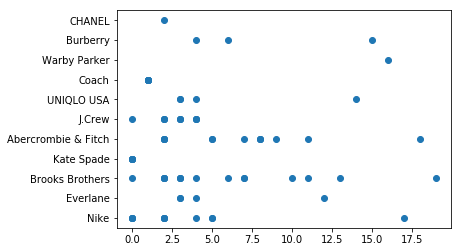

In [211]:
import matplotlib.pyplot as plt

plt.scatter(dummies["clusters"], dummies["company"])
plt.show()